In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy import stats

Read Dataset

In [2]:
data = pd.read_csv(r"C:\Users\future\Downloads\OnlineRetail.csv", encoding='latin1')

DATA EXPLORATION

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
data.shape

(541909, 8)

In [6]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
data = data.dropna()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [9]:
data.shape

(406829, 8)

In [10]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


DATA CLEANING

In [11]:
data["CustomerID"] = data["CustomerID"].astype(str)
data["Amount"] = data["Quantity"]*data["UnitPrice"]
Data_m = data.groupby("CustomerID")["Amount"].sum()
Data_m.reset_index()
Data_m.columns= ["CustomerID","Amount"]
print(Data_m)

CustomerID
12346.0       0.00
12347.0    4310.00
12348.0    1797.24
12349.0    1757.55
12350.0     334.40
            ...   
18280.0     180.60
18281.0      80.82
18282.0     176.60
18283.0    2094.88
18287.0    1837.28
Name: Amount, Length: 4372, dtype: float64


In [12]:
Data_f = data.groupby("CustomerID")["InvoiceNo"].count()
Data_f = Data_f.reset_index()
Data_f.columns= ["CustomerID","Frequency"]
print(Data_f)

     CustomerID  Frequency
0       12346.0          2
1       12347.0        182
2       12348.0         31
3       12349.0         73
4       12350.0         17
...         ...        ...
4367    18280.0         10
4368    18281.0          7
4369    18282.0         13
4370    18283.0        756
4371    18287.0         70

[4372 rows x 2 columns]


In [13]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"],format='%m/%d/%Y %H:%M')
max_date = max(data["InvoiceDate"])
data["Diff"] = max_date - data["InvoiceDate"]
Data_p= data.groupby("CustomerID")["Diff"].min()
Data_p = Data_p.reset_index()
Data_p.columns= ["CustomerID","Diff"]
Data_p["Diff"] = Data_p["Diff"].dt.days
print(Data_p)

     CustomerID  Diff
0       12346.0   325
1       12347.0     1
2       12348.0    74
3       12349.0    18
4       12350.0   309
...         ...   ...
4367    18280.0   277
4368    18281.0   180
4369    18282.0     7
4370    18283.0     3
4371    18287.0    42

[4372 rows x 2 columns]


In [14]:
Data_final = pd.merge(Data_m , Data_f , on="CustomerID" , how="inner")
Data_final = pd.merge(Data_final , Data_p , on="CustomerID" , how="inner")
Data_final.columns = ["CustomerID" , "Amount" , "Frequency", "Recency"]
print(Data_final.head())

  CustomerID   Amount  Frequency  Recency
0    12346.0     0.00          2      325
1    12347.0  4310.00        182        1
2    12348.0  1797.24         31       74
3    12349.0  1757.55         73       18
4    12350.0   334.40         17      309


In [21]:
#outliers
Q1 = Data_final.Amount.quantile(0.25)
Q3 = Data_final.Amount.quantile(0.75)
IQR = Q3-Q1
Data_final = Data_final[(Data_final.Amount>= Q1- 1.5*IQR) & (Data_final.Amount<= Q3+ 1.5*IQR)]
Q1 = Data_final.Amount.quantile(0.25)
Q3 = Data_final.Amount.quantile(0.75)
IQR = Q3-Q1
Data_final = Data_final[(Data_final.Recency>= Q1- 1.5*IQR) & (Data_final.Recency<= Q3+ 1.5*IQR)]
Q1 = Data_final.Amount.quantile(0.25)
Q3 = Data_final.Amount.quantile(0.75)
IQR = Q3-Q1


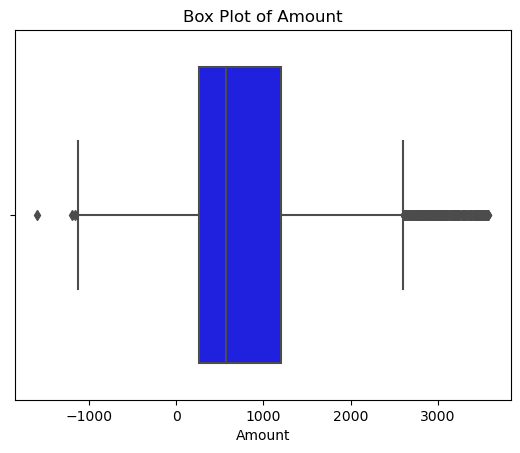

In [16]:
sns.boxplot(x=Data_final['Amount'], color='blue')
plt.xlabel('Amount')
plt.title('Box Plot of Amount')
plt.show()

DATA VISUALIZATION

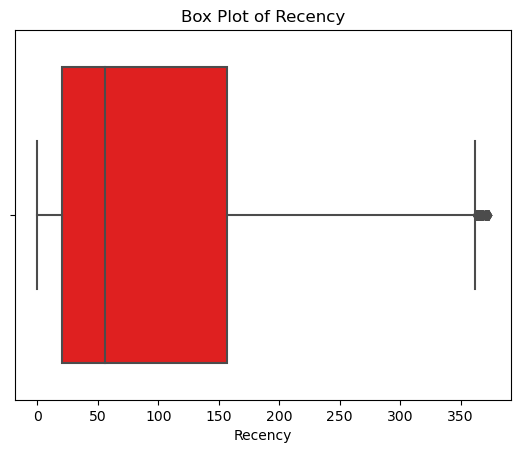

In [19]:
sns.boxplot(x=Data_final['Recency'], color='red')
plt.xlabel('Recency')
plt.title('Box Plot of Recency')
plt.show()

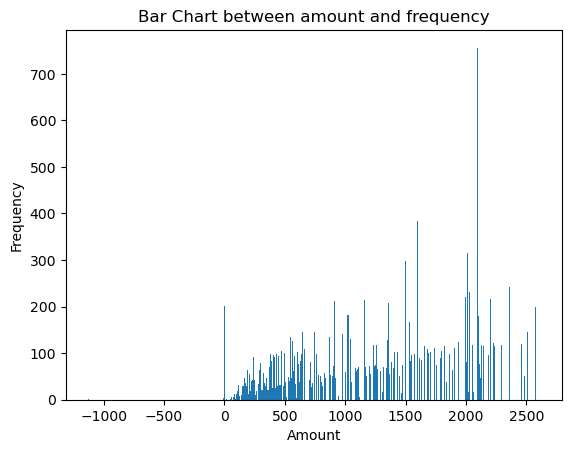

In [22]:
plt.bar(Data_final['Amount'], Data_final['Frequency'])
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Bar Chart between amount and frequency')
plt.show()

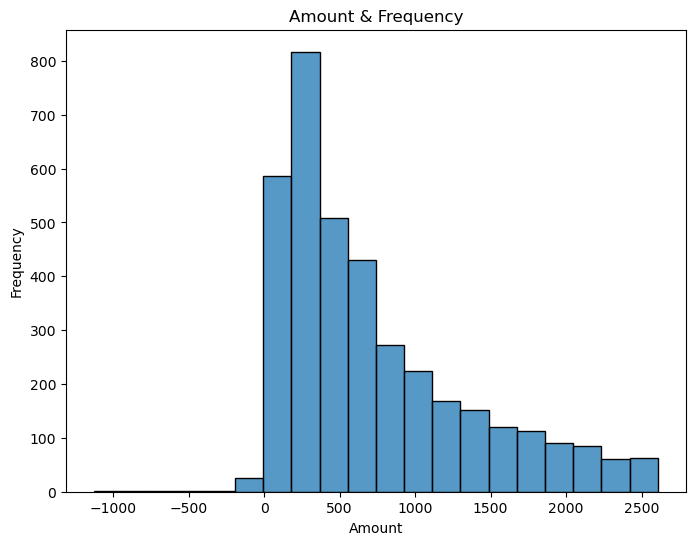

In [23]:
# Histogram for Visualize 

plt.figure(figsize=(8, 6))
sns.histplot(Data_final['Amount'], bins=20)
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Amount & Frequency')
plt.show()

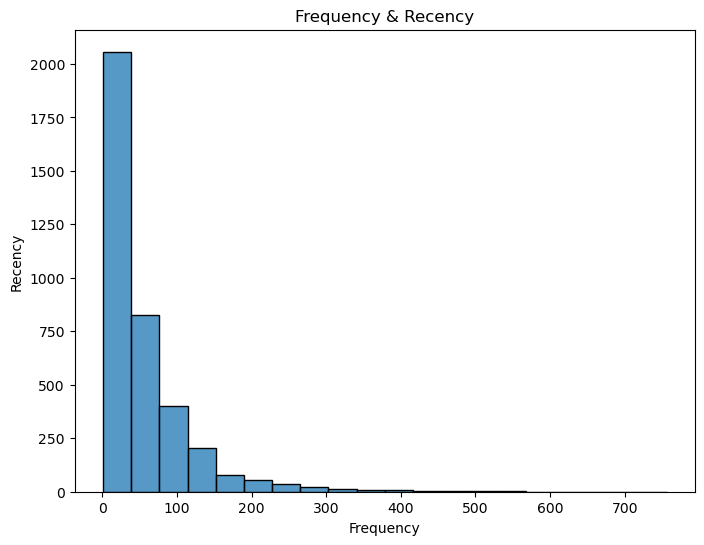

In [24]:
# Histogram for Visualize 

plt.figure(figsize=(8, 6))
sns.histplot(Data_final['Frequency'], bins=20)
plt.xlabel('Frequency')
plt.ylabel('Recency')
plt.title('Frequency & Recency')
plt.show()

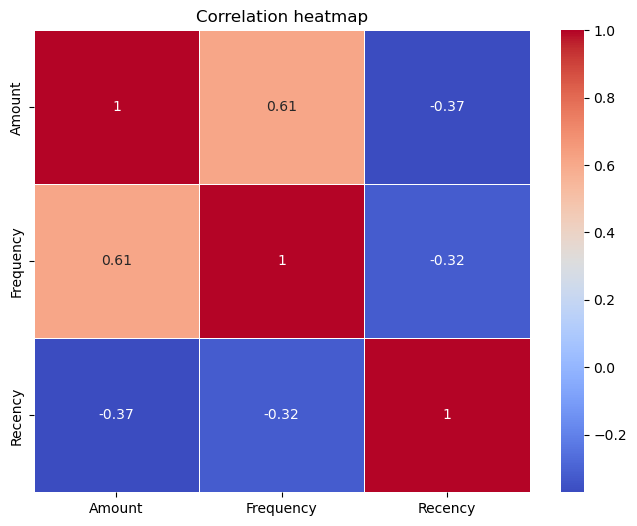

In [25]:
correlation_matrix = Data_final[["Amount" , "Frequency" , "Recency"]].corr()
# correlation matrix

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation heatmap')
plt.show()

In [26]:
#scaling
S = Data_final[["Amount" , "Frequency" , "Recency"]]
scaler = MinMaxScaler()
Data_scaled = scaler.fit_transform(S)

In [27]:
Data_scaled = pd.DataFrame(Data_scaled)
Data_scaled.columns = ["Amount" , "Frequency" , "Recency"]
Data_scaled.head()

,Amount,Frequency,Recency
0,0.301672,0.001325,0.871314
1,0.783179,0.039735,0.198391
2,0.772546,0.095364,0.048257
3,0.391263,0.021192,0.828418
4,0.715710,0.124503,0.093834


KMEANS MODEL

In [28]:
#model creation
kmeans = KMeans(n_clusters=3, max_iter=50 , random_state=42)
kmeans.fit(Data_scaled)
lbs = kmeans.labels_
print(lbs)

C:\Users\future\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 0 0 ... 2 0 0]


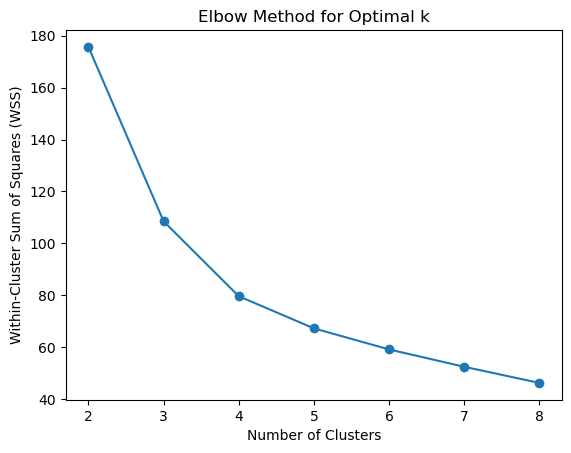

In [29]:
wss = []
range_n_clusters= [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init=10)  # Set n_init explicitly
    kmeans.fit(Data_scaled)
    wss.append(kmeans.inertia_)

plt.plot(range_n_clusters, wss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.title('Elbow Method for Optimal k')
plt.show()


evaluate the model using silhouette_score

In [30]:
# Assuming Data_scaled contains your scaled data

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init=10)
    kmeans.fit(Data_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(Data_scaled, cluster_labels)
    print("n_clusters={0}, the average silhouette_score is {1}".format(num_clusters, silhouette_avg))

n_clusters=2, the average silhouette_score is 0.5431103708936064
n_clusters=3, the average silhouette_score is 0.47731240854278606
n_clusters=4, the average silhouette_score is 0.45109237543908237
n_clusters=5, the average silhouette_score is 0.3769111156803094
n_clusters=6, the average silhouette_score is 0.35468900867813796
n_clusters=7, the average silhouette_score is 0.3582732609138321
n_clusters=8, the average silhouette_score is 0.36293758458778225


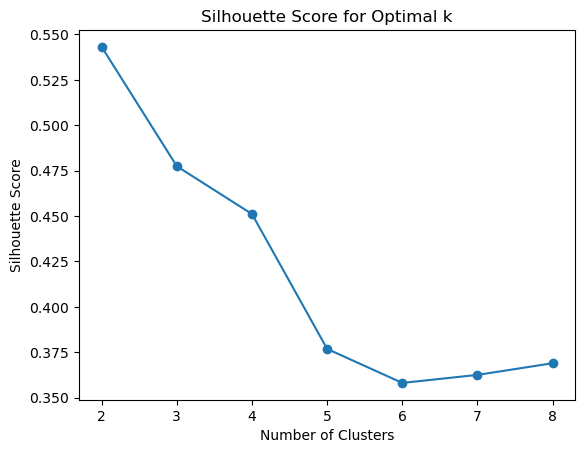

In [31]:
def perform_clustering(data, n_clusters):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    silhouette_scores = []

    for num_clusters in n_clusters:
        kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init=10, random_state=42)
        kmeans.fit(data_scaled)
        cluster_labels = kmeans.labels_
        
        silhouette_avg = silhouette_score(data_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        

    return silhouette_scores

# Plotting the Silhouette Score graph
silhouette_scores = perform_clustering(Data_final[['Amount', 'Frequency', 'Recency']], range_n_clusters)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

In [32]:
Data_final["Cluster_ID"] = lbs
Data_final.head()

,CustomerID,Amount,Frequency,Recency,Cluster_ID
0,12346.0,0.00,2,325,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1
5,12352.0,1545.41,95,35,0


<Axes: xlabel='Cluster_ID', ylabel='Amount'>

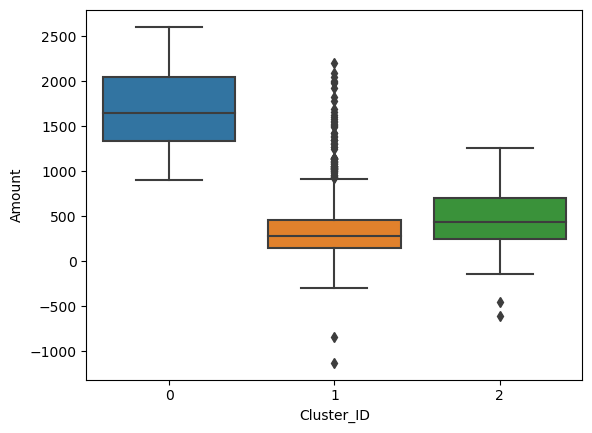

In [33]:
sns.boxplot(x="Cluster_ID" ,y= "Amount",data=Data_final)

<Axes: xlabel='Cluster_ID', ylabel='Frequency'>

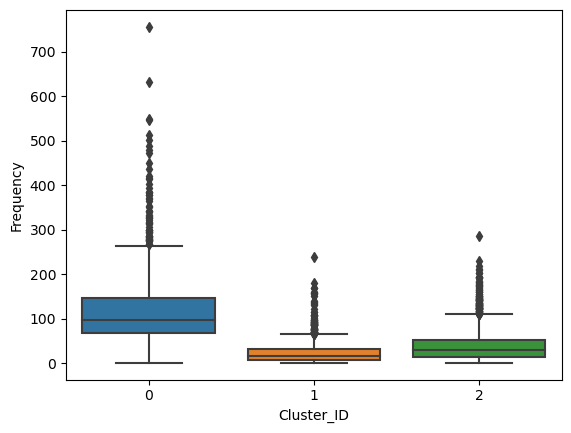

In [34]:
sns.boxplot(x="Cluster_ID" ,y= "Frequency",data=Data_final)

<Axes: xlabel='Cluster_ID', ylabel='Recency'>

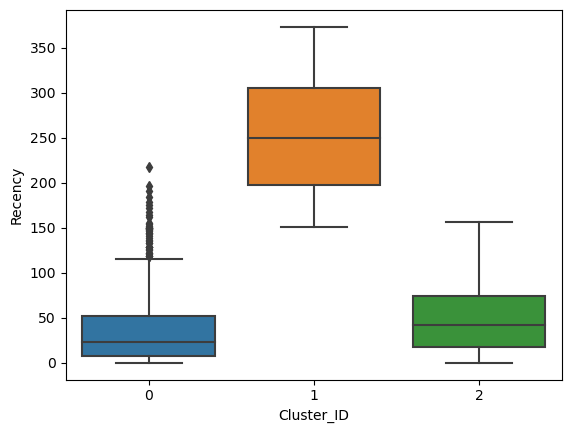

In [35]:
sns.boxplot(x="Cluster_ID" ,y= "Recency",data=Data_final)

evaluate the model using davies_bouldin_score

Davies-Bouldin Index for the clusters: 0.7706768982004969


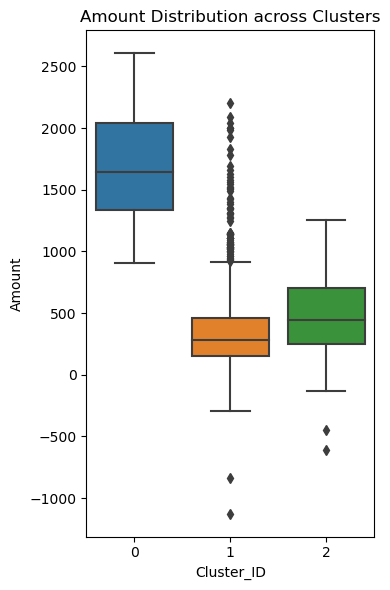

In [36]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_avg = davies_bouldin_score(Data_scaled, lbs)
print(f"Davies-Bouldin Index for the clusters: {davies_bouldin_avg}")

# Visualizing Clusters
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x="Cluster_ID", y="Amount", data=Data_final)
plt.title('Amount Distribution across Clusters')
plt.tight_layout()
plt.show()

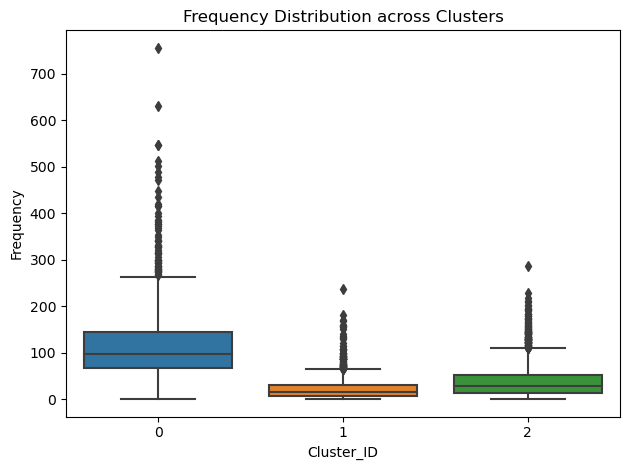

In [37]:

sns.boxplot(x="Cluster_ID", y="Frequency", data=Data_final)
plt.title('Frequency Distribution across Clusters')
plt.tight_layout()
plt.show()

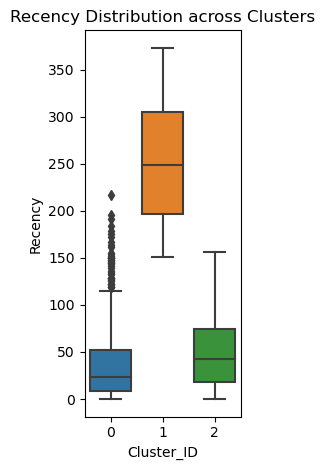

In [38]:
plt.subplot(1, 3, 3)
sns.boxplot(x="Cluster_ID", y="Recency", data=Data_final)
plt.title('Recency Distribution across Clusters')

plt.tight_layout()
plt.show()

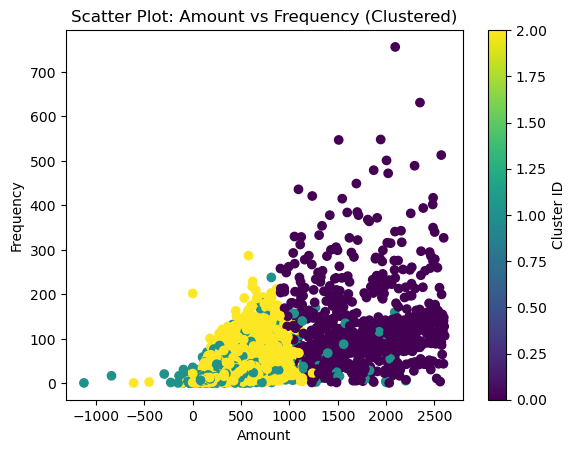

In [43]:
plt.scatter(Data_final['Amount'], Data_final['Frequency'], c=Data_final['Cluster_ID'], cmap='viridis')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Scatter Plot: Amount vs Frequency (Clustered)')
plt.colorbar(label='Cluster ID')
plt.show()

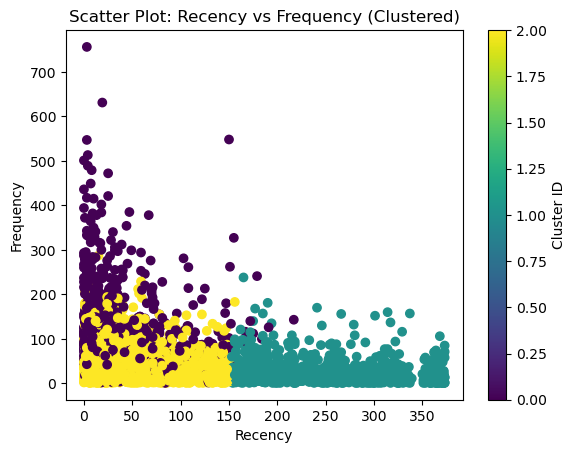

In [44]:
# Scatter plot between Recency and Frequency colored by Cluster ID
plt.scatter(Data_final['Recency'], Data_final['Frequency'], c=Data_final['Cluster_ID'], cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Scatter Plot: Recency vs Frequency (Clustered)')
plt.colorbar(label='Cluster ID')
plt.show()

In [45]:
pip install --upgrade matplotlib


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: matplotlib in c:\users\future\anaconda3\lib\site-packages (3.7.0)
     ---------------------------------------- 7.6/7.6 MB 384.4 kB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.0
    Uninstalling matplotlib-3.7.0:



ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\future\\anaconda3\\lib\\site-packages\\matplotlib\\backends\\_backend_agg.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



Make a pipeline

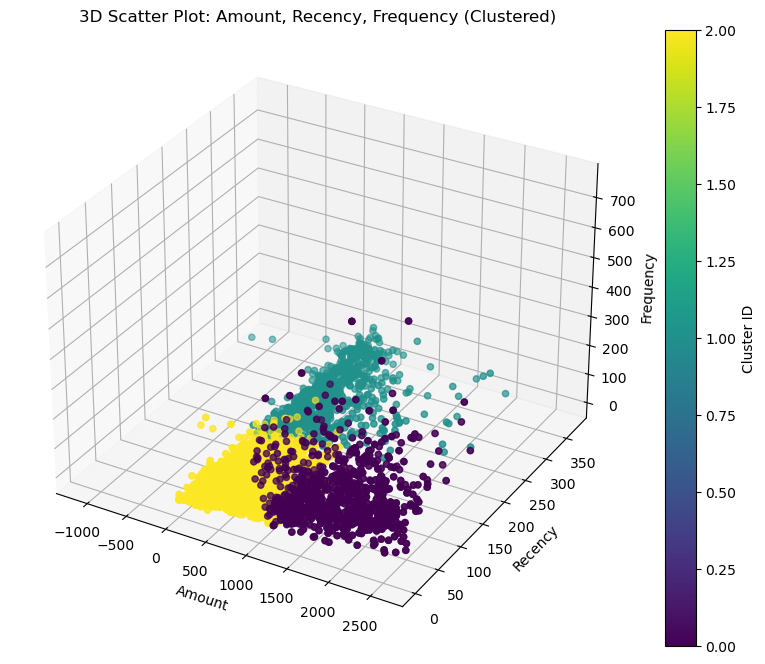

In [46]:
# 3D Scatter plot between Amount, Recency, and Frequency colored by Cluster ID
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Data_final['Amount'], Data_final['Recency'], Data_final['Frequency'], c=Data_final['Cluster_ID'], cmap='viridis')
ax.set_xlabel('Amount')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')
ax.set_title('3D Scatter Plot: Amount, Recency, Frequency (Clustered)')
plt.colorbar(ax.scatter(Data_final['Amount'], Data_final['Recency'], Data_final['Frequency'], c=Data_final['Cluster_ID'], cmap='viridis'), label='Cluster ID')
plt.show()

In [42]:
from sklearn.pipeline import Pipeline

# Assuming you've already defined 'Data_final' and 'Data_scaled'

# Create a pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Scaling the data
    ('kmeans', KMeans(n_clusters=3, max_iter=50, random_state=42))  # KMeans clustering
])

# Fit the pipeline to your data
pipeline.fit(Data_final[['Amount', 'Frequency', 'Recency']])

# Predicting clusters for the data
predicted_clusters = pipeline.predict(Data_final[['Amount', 'Frequency', 'Recency']])

# Adding predicted clusters to the DataFrame
Data_final['Predicted_Clusters'] = predicted_clusters

# Display the head of the DataFrame with predicted clusters
print(Data_final.head())


C:\Users\future\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  CustomerID   Amount  Frequency  Recency  Cluster_ID  Predicted_Clusters
0    12346.0     0.00          2      325           1                   1
2    12348.0  1797.24         31       74           0                   0
3    12349.0  1757.55         73       18           0                   0
4    12350.0   334.40         17      309           1                   1
5    12352.0  1545.41         95       35           0                   0
